--- Initialization ---
SpellChecker initialized with default dictionary.
Attempting to manually load custom dictionary from: /app/data/custom_dict.txt
Successfully added 11 words manually using spell.known().
Finding image files...
Selected sample image: /app/data/Dilbert_1989-2023/1989/1989-04-16_dog_brain_animals.gif

--- Processing Sample Image: 1989-04-16_dog_brain_animals.gif ---
Info: OpenCV failed for GIF, attempting Pillow fallback: 1989-04-16_dog_brain_animals.gif
  Found 5 panels.
    Processing Panel 0...
      Found 2 text blocks.
  Displaying debug image steps for Panel 0...


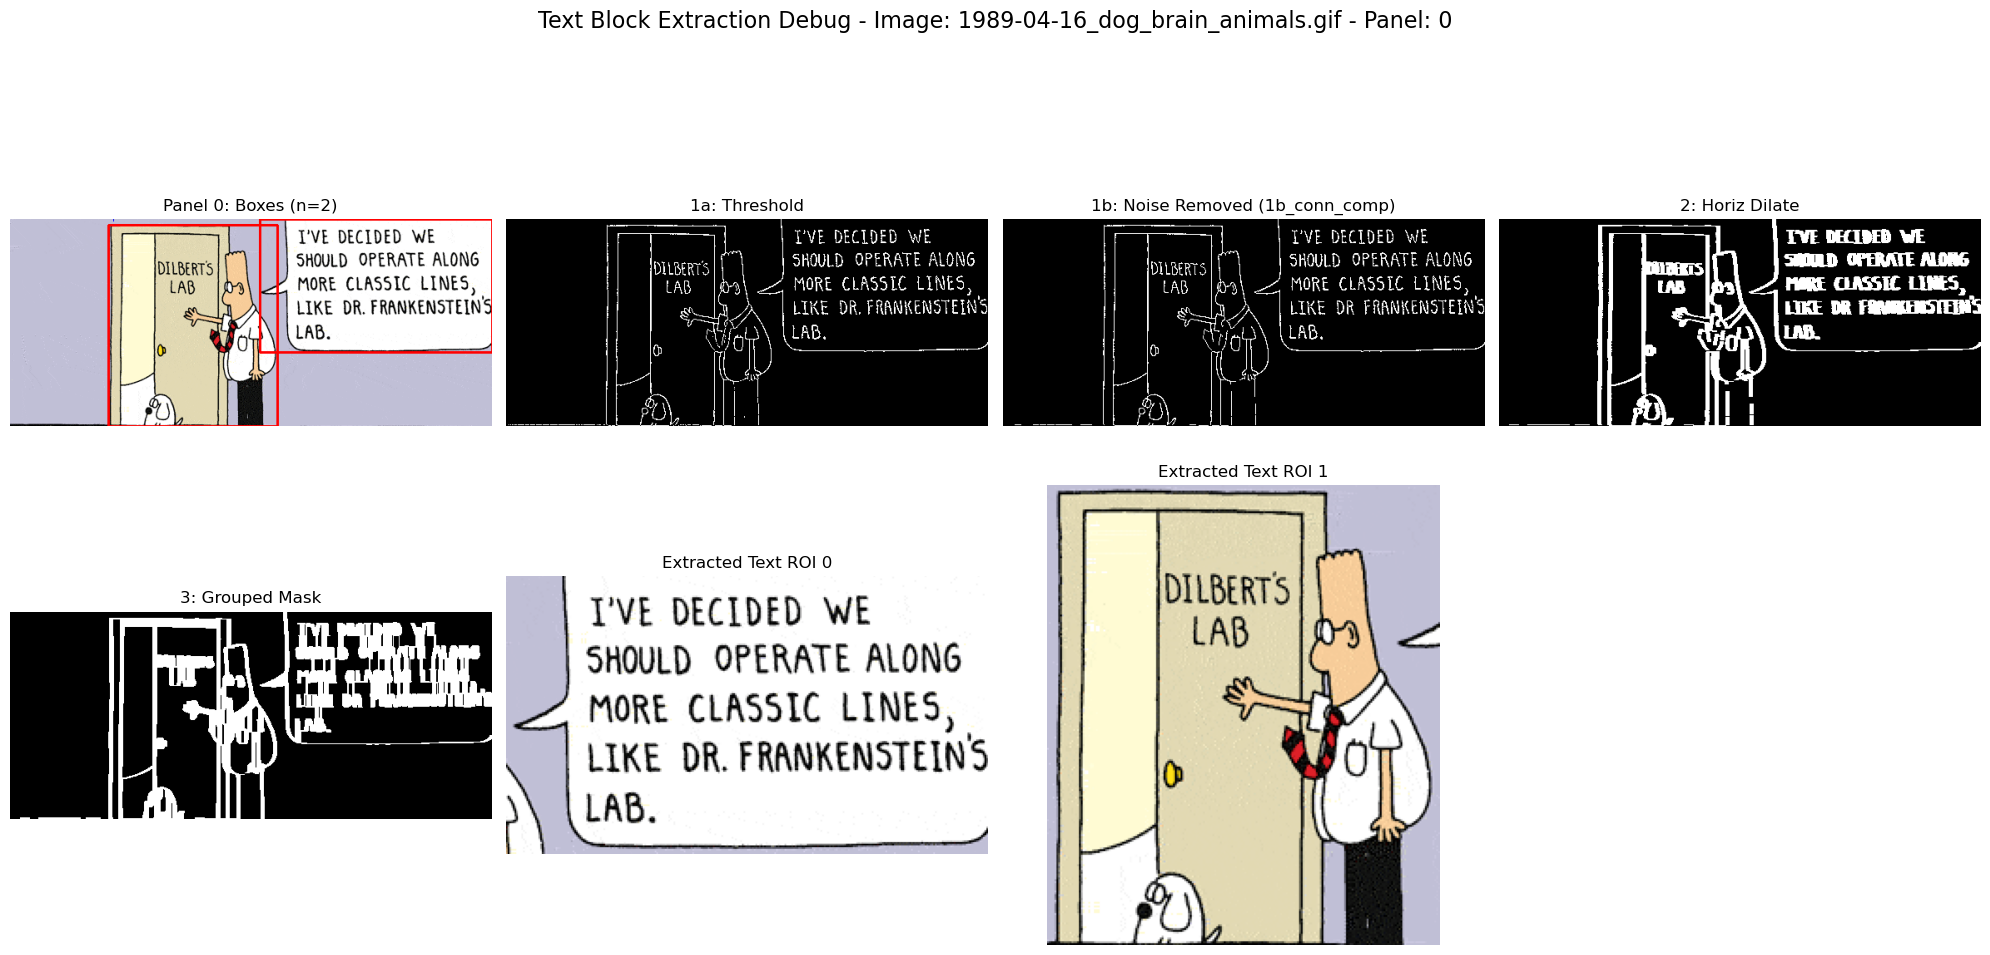

        Block 0: OK -> 't we decided we should operate along more classic lines like do frankenstein lab...'
        Block 1: OK -> 'he i...'
    Processing Panel 1...
      Found 4 text blocks.
  Displaying debug image steps for Panel 1...


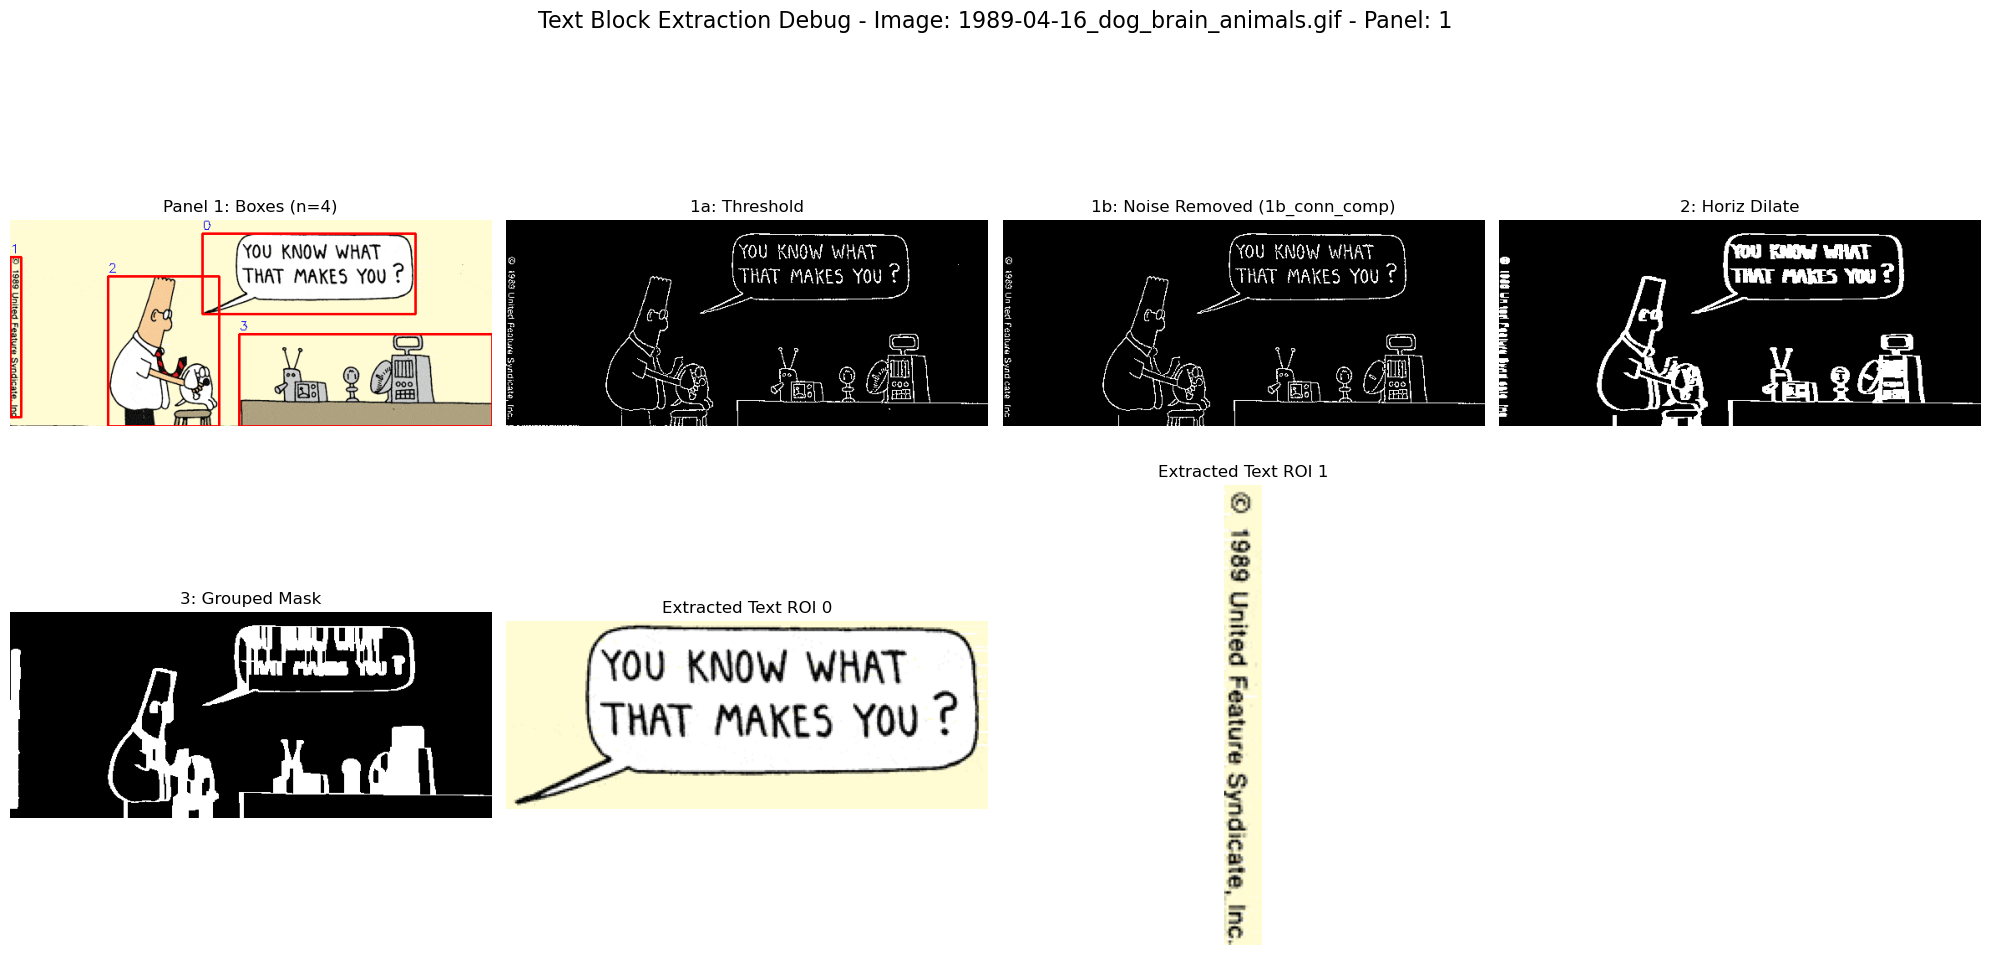

        Block 0: OK -> 'you know what that makes you...'
        Block 1: Skipping short corrected text: '4...'
        Block 2: Skipping short/empty/error raw OCR: 'Ay...'
        Block 3: OK -> 'en poem...'
    Processing Panel 2...
      Found 5 text blocks.
  Displaying debug image steps for Panel 2...


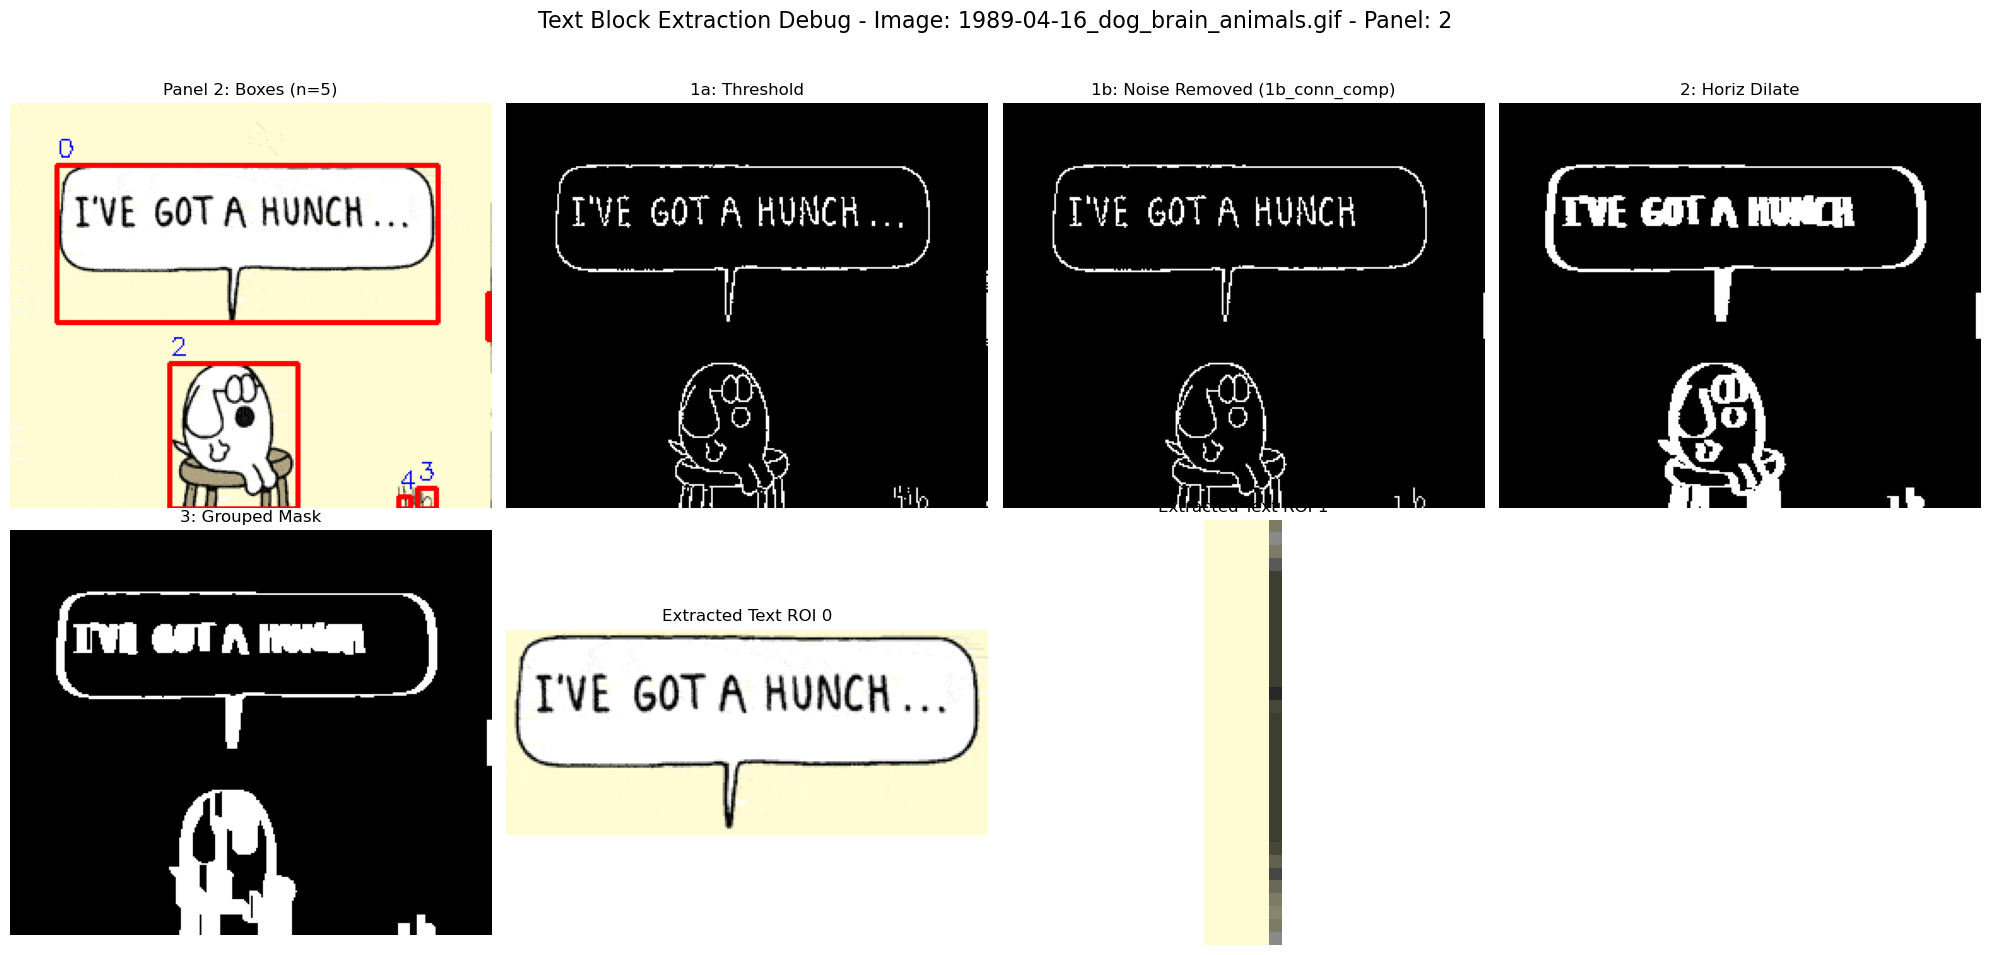

        Block 0: Skipping short/empty/error raw OCR: '[OCR Result Empty]...'
        Block 1: Skipping short/empty/error raw OCR: '[OCR Result Empty]...'
        Block 2: OK -> '£*,...'
        Block 3: Skipping short/empty/error raw OCR: 'ib...'
        Block 4: Skipping short/empty/error raw OCR: '”...'
    Processing Panel 3...
      Found 4 text blocks.
  Displaying debug image steps for Panel 3...


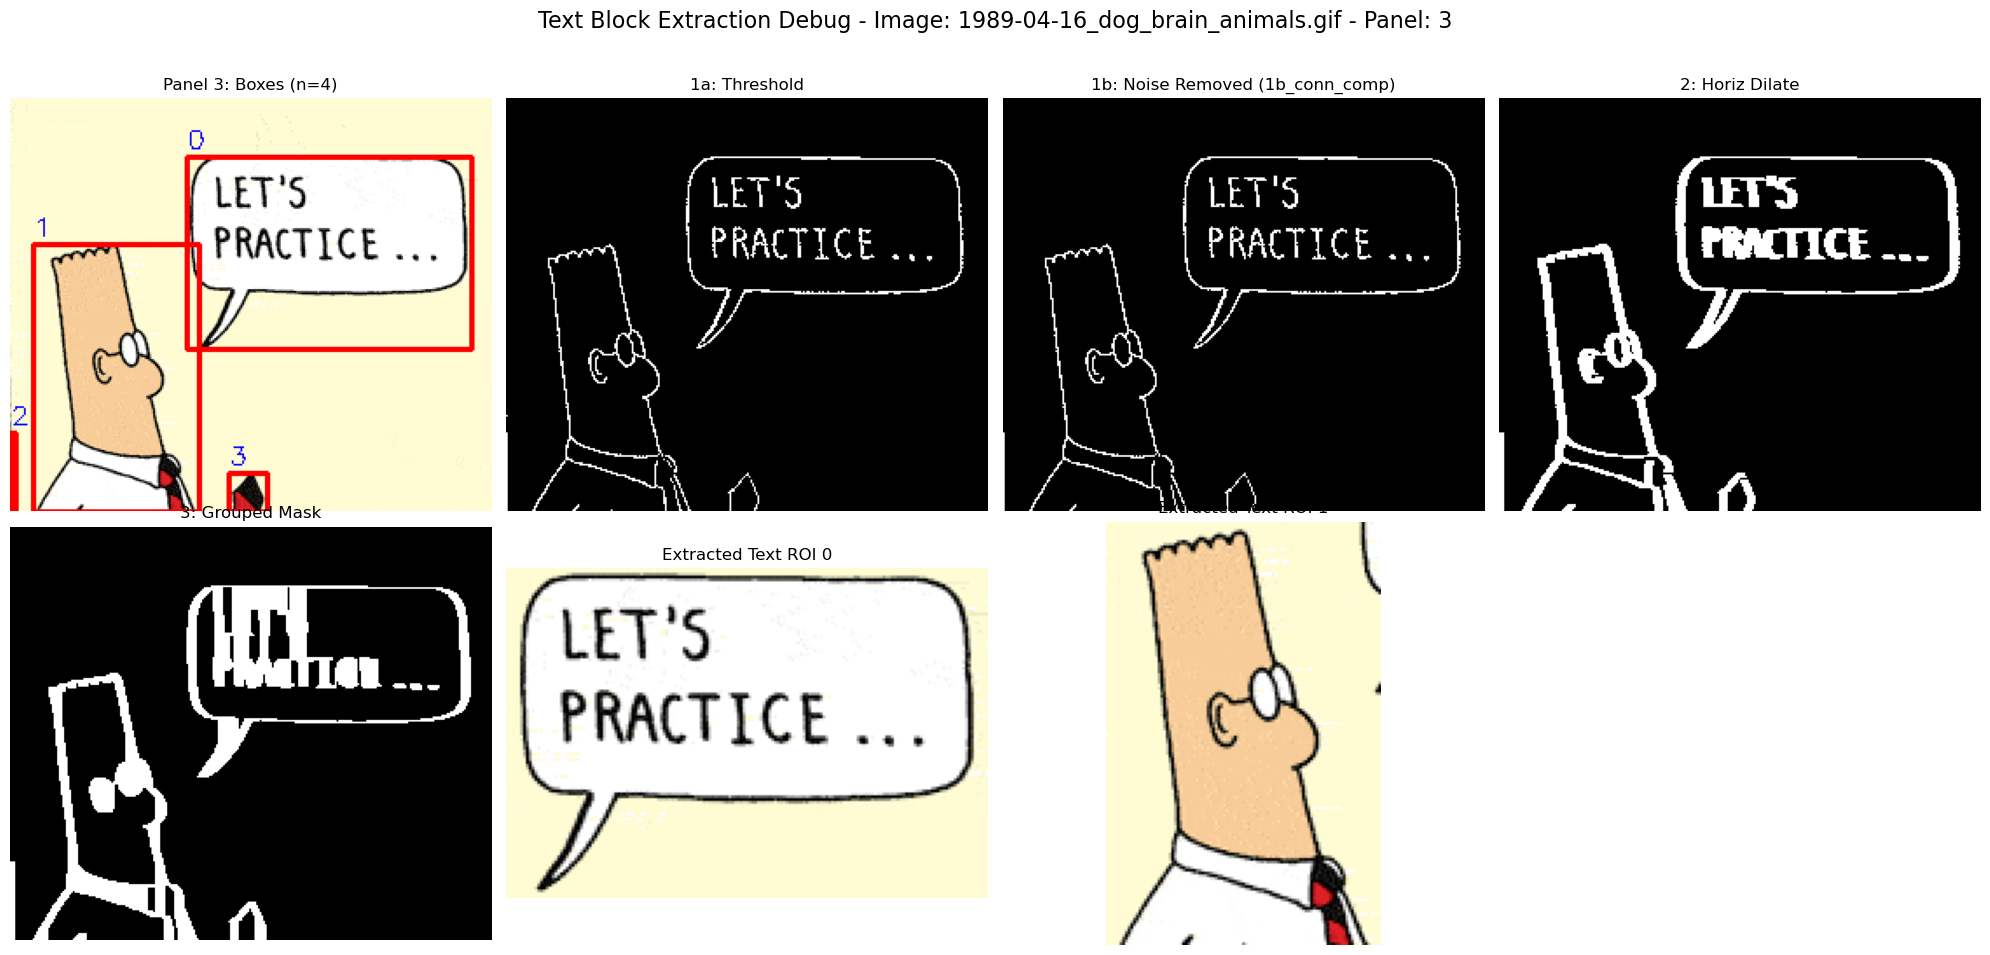

        Block 0: OK -> 'let s practice...'
        Block 1: Skipping short/empty/error raw OCR: 'is...'
        Block 2: Skipping short/empty/error raw OCR: '[OCR Result Empty]...'
        Block 3: Skipping short/empty/error raw OCR: '[OCR Result Empty]...'
    Processing Panel 4...
      Found 5 text blocks.
  Displaying debug image steps for Panel 4...


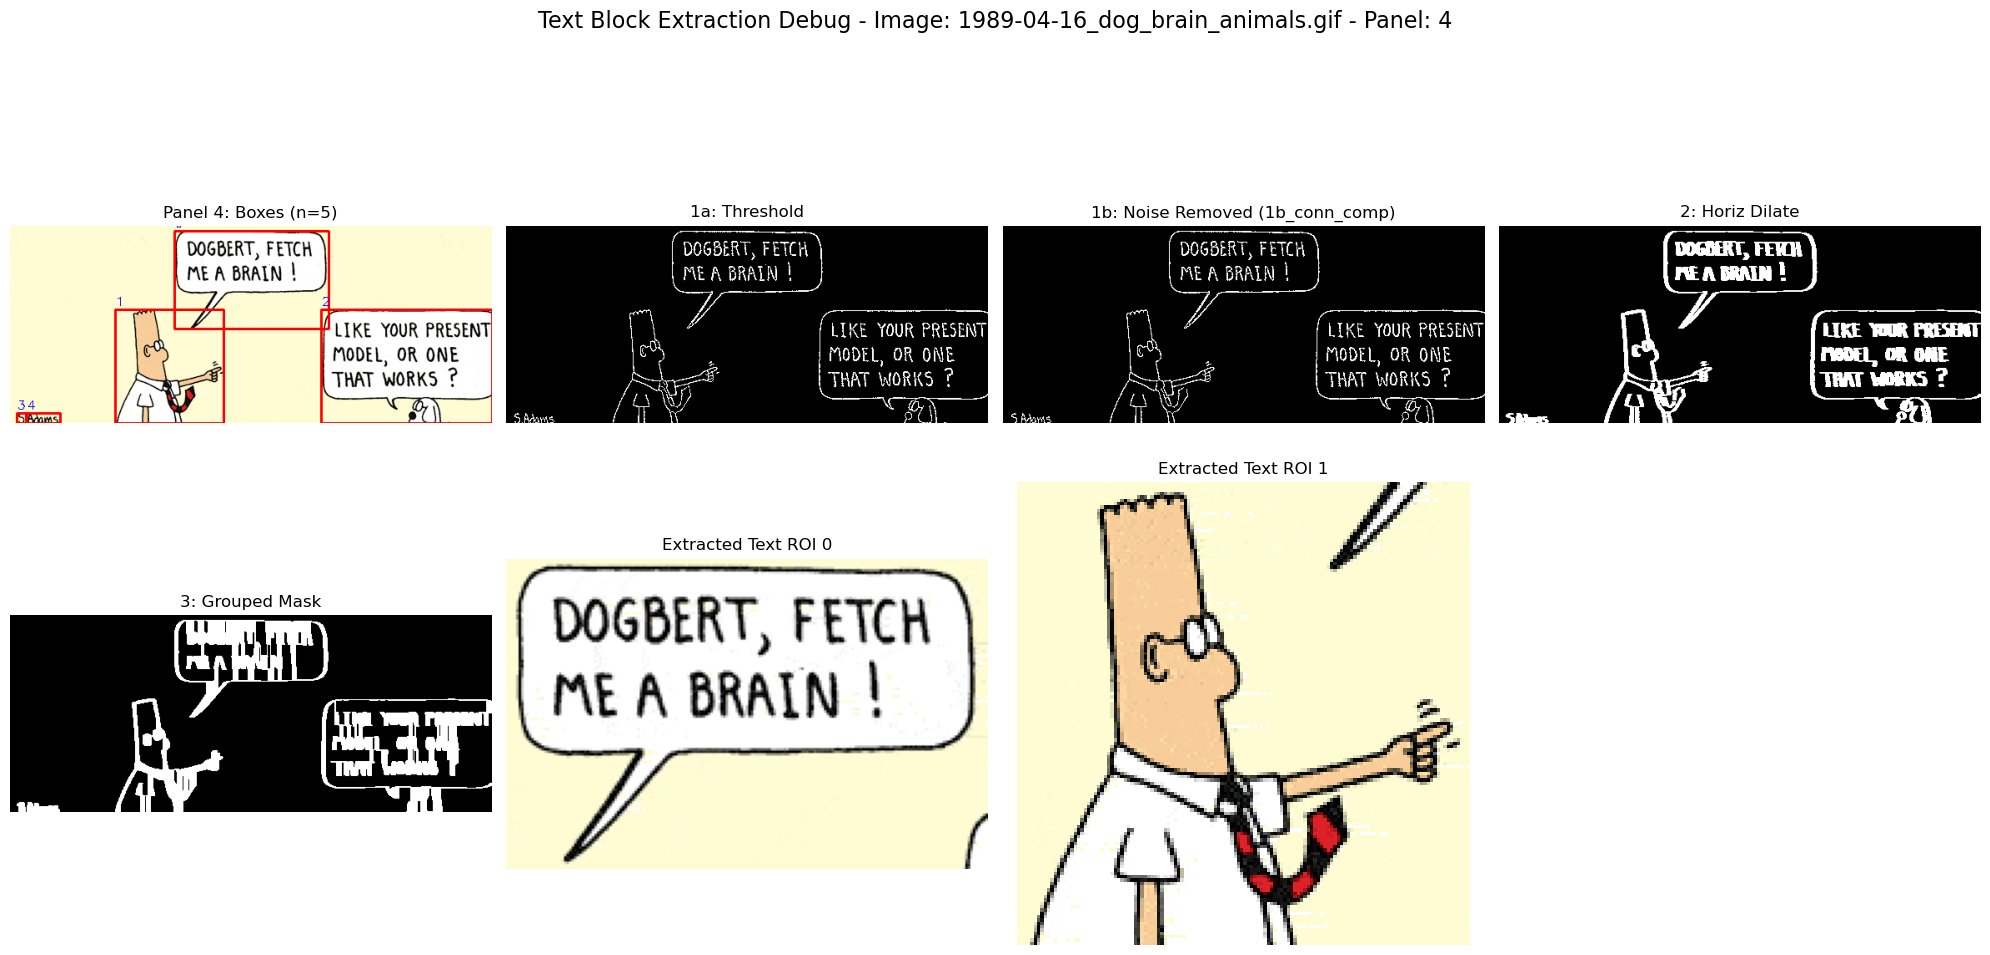

        Block 0: OK -> 'dogberry fetch me brain...'
        Block 1: Skipping short/empty/error raw OCR: '[OCR Result Empty]...'
        Block 2: OK -> 'like your present model or one that works e...'
        Block 3: Skipping short corrected text: 'ss...'
        Block 4: OK -> 'dams...'

--- Finished processing 1989-04-16_dog_brain_animals.gif in 6.00 seconds ---
Extracted 9 text blocks total from this image.

Results for this image (JSON format):
[
  {
    "image_filename": "1989-04-16_dog_brain_animals.gif",
    "image_path": "/app/data/Dilbert_1989-2023/1989/1989-04-16_dog_brain_animals.gif",
    "panel_index": 0,
    "text_block_index": 0,
    "panel_bounding_box": [
      305,
      5,
      279,
      160
    ],
    "raw_ocr_text": "T'VE DECIDED WE  SHOULD OPERATE ALONG  MORE CLASSIC LINES,  LIKE DR. FRANKENSTEIN \\ LAB.",
    "extracted_text": "t we decided we should operate along more classic lines like do frankenstein lab"
  },
  {
    "image_filename": "1989-04-16_dog_brain

In [13]:
import cv2
import numpy as np
import pytesseract
import re
import json
import pathlib
import os
import matplotlib.pyplot as plt # Keep for potential final display if needed
from spellchecker import SpellChecker
import time # Optional: For timing execution
import matplotlib.pyplot as plt

print("--- Initialization ---")

# --- 2. Configuration & Global Constants ---
# Ensure DATA_DIR points to the correct path inside the container
DATA_DIR = pathlib.Path("/app/data")
ALLOWED_EXTENSIONS = {'.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tif', '.tiff'}
TESSERACT_CONFIG = "--oem 3 --psm 6" # Default Tesseract config
OCR_LANGUAGE = 'eng'
CUSTOM_DICT_FILENAME = 'custom_dict.txt' # Filename for custom dictionary
CROP_PIXELS = 5 # Pixels to trim from panel borders
ENABLE_DEBUG_PLOTTING = True

# FINAL TUNED PARAMETERS for text block extraction
TEXT_BLOCK_PARAMS = {
    "adapt_thresh_block_size": 5,
    "adapt_thresh_C": 35,
    "morph_kernel_h_size": (5, 1),
    "morph_kernel_v_size": (1, 13),
    "morph_iterations_h": 1,
    "morph_iterations_v": 1,
    "min_noise_area_pixels": 7,
    "min_text_area_ratio": 0.0005,
    "max_text_area_ratio": 0.6,
    "min_aspect_ratio": 0.05,
    "max_aspect_ratio": 25.0,
    "roi_padding": 3,
    "debug_draw": True
}

# --- 3. Helper Function Definitions ---

def find_image_files(root_dir_path: pathlib.Path, allowed_extensions: set) -> list[pathlib.Path]:
    """Recursively finds all files with allowed extensions."""
    image_files = []
    if not root_dir_path.is_dir():
        print(f"Error: Directory not found at {root_dir_path}")
        return []
    for item in root_dir_path.rglob('*'):
        if item.is_file() and item.suffix.lower() in allowed_extensions:
            image_files.append(item)
    image_files.sort()
    return image_files

def load_image_flexible(image_path: str) -> np.ndarray | None:
    """Loads an image using OpenCV, falling back to Pillow for GIFs."""
    img_bgr = None
    file_extension = pathlib.Path(image_path).suffix.lower()
    img_cv = cv2.imread(image_path)
    if img_cv is not None:
        img_bgr = img_cv
    elif img_cv is None and file_extension == '.gif':
        print(f"Info: OpenCV failed for GIF, attempting Pillow fallback: {pathlib.Path(image_path).name}")
        try:
            from PIL import Image, UnidentifiedImageError # Import here if not global
            with Image.open(image_path) as pil_img:
                pil_img.seek(0)
                img_rgb = pil_img.convert('RGB')
                img_bgr = cv2.cvtColor(np.array(img_rgb), cv2.COLOR_RGB2BGR)
        except (UnidentifiedImageError, EOFError, Exception) as e:
            print(f"Error loading GIF with Pillow: {e}")
            img_bgr = None
    else:
        print(f"Error: OpenCV failed to load image: {image_path}")
        img_bgr = None
    return img_bgr

# --- Debug Plotting Helper Functions ---
def display_image(ax, title, image, cmap=None):
    """
    Displays a single image on a given matplotlib Axes object.
    Handles BGR to RGB conversion for color images if cmap is None.
    """
    if image is None or image.size == 0:
        # Display placeholder if image is missing
        ax.set_title(f"{title}\n(Image N/A)")
        # Add text placeholder to make it clear
        ax.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=12, color='grey', transform=ax.transAxes)
        ax.set_xticks([]) # Turn off ticks
        ax.set_yticks([])
        ax.axis('off') # Ensure axis is fully off
        return

    try:
        # Determine image type for correct display
        if cmap is None and len(image.shape) == 3 and image.shape[2] == 3:
            # Assume BGR color, convert to RGB for display
            ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        elif cmap is not None and len(image.shape) == 2:
            # Grayscale image
            ax.imshow(image, cmap=cmap)
        else:
            # Fallback (might be already RGB or single channel without cmap)
            ax.imshow(image, cmap=cmap) # Pass cmap even if None

        ax.set_title(title)
    except Exception as e:
        ax.set_title(f"{title}\n(Plotting Error: {e})")
        # Attempt to show problematic shape
        ax.text(0.5, 0.5, f"Error plotting\nShape:{image.shape}", ha='center', va='center', fontsize=9, color='red', transform=ax.transAxes)

    ax.axis('off') # Hide axes ticks and labels

def display_text_extraction_debug_steps(image_filename, panel_index,
                                        panel_with_boxes, debug_imgs_dict, text_rois):
    """
    Displays the intermediate steps and results of text block extraction
    for a single panel in a subplot grid.
    """
    # Validate necessary inputs for plotting
    if panel_with_boxes is None:
         print(f"  Skipping debug plot for Panel {panel_index}: panel_with_boxes is None.")
         return
    if not isinstance(debug_imgs_dict, dict):
        print(f"  Skipping debug plot for Panel {panel_index}: debug_imgs_dict is not a dictionary.")
        return

    print(f"  Displaying debug image steps for Panel {panel_index}...")

    # Define plot layout (adjust rows/cols as needed)
    rows, cols = 2, 4 # 8 slots total
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10)) # Adjust figsize as needed
    fig.suptitle(f"Text Block Extraction Debug - Image: {image_filename} - Panel: {panel_index}", fontsize=16)
    axes_flat = axes.flatten() # Flatten grid for easy indexing

    # --- Plot the images in predefined slots using the helper ---

    # Slot 1: Final Panel with Detected Boxes
    display_image(axes_flat[0], f"Panel {panel_index}: Boxes (n={len(text_rois)})", panel_with_boxes)

    # Slot 2: Initial Threshold
    thresh_key = '1a_threshold' # Key used in extract_text_blocks_from_panel
    display_image(axes_flat[1], "1a: Threshold", debug_imgs_dict.get(thresh_key), cmap='gray')

    # Slot 3: Noise Removal Result (handle different possible keys)
    noise_removed_key = None
    noise_img = None
    if '1b_conn_comp' in debug_imgs_dict:
        noise_removed_key = '1b_conn_comp'
        noise_img = debug_imgs_dict.get(noise_removed_key)
    elif '1b_opened' in debug_imgs_dict:
        noise_removed_key = '1b_opened'
        noise_img = debug_imgs_dict.get(noise_removed_key)
    display_image(axes_flat[2], f"1b: Noise Removed ({noise_removed_key or 'N/A'})", noise_img, cmap='gray')

    # Slot 4: Horizontal Dilation
    display_image(axes_flat[3], "2: Horiz Dilate", debug_imgs_dict.get('2_dilate_h'), cmap='gray')

    # Slot 5: Grouped Mask
    display_image(axes_flat[4], "3: Grouped Mask", debug_imgs_dict.get('3_grouped_mask'), cmap='gray')

    # Slot 6: First Extracted Text ROI
    roi_0 = text_rois[0] if text_rois else None
    display_image(axes_flat[5], "Extracted Text ROI 0", roi_0)

    # Slot 7: Second Extracted Text ROI
    roi_1 = text_rois[1] if len(text_rois) > 1 else None
    display_image(axes_flat[6], "Extracted Text ROI 1", roi_1)

    # Hide any unused subplots (e.g., slot 8 in 2x4)
    for i in range(7, rows * cols):
         axes_flat[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show() # Display the plot

    


def extract_comic_panels(image_path: str, threshold_val: int = 200, min_panel_area_ratio: float = 0.005, debug_draw: bool = False):
    """Loads image, detects/orders comic panels based on borders/gutters."""
    img = load_image_flexible(image_path)
    if img is None: return [], None, None, None
    h_orig, w_orig, c_orig = img.shape
    original_dimensions = (h_orig, w_orig, c_orig)
    aspect_ratio = float(w_orig) / h_orig if h_orig > 0 else 0

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, threshold_val, 255, cv2.THRESH_BINARY_INV)[1]
    # Optional morphology for panel borders if needed...
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = (w_orig * h_orig) * min_panel_area_ratio
    panel_boxes = []
    valid_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_area:
            x, y, w_cnt, h_cnt = cv2.boundingRect(cnt)
            panel_boxes.append((x, y, w_cnt, h_cnt))
            valid_contours.append(cnt)

    if not panel_boxes: return [], None, original_dimensions, aspect_ratio
    sorted_panel_boxes = sorted(panel_boxes, key=lambda box: (box[1], box[0]))
    scenes = []
    for (x, y, w_box, h_box) in sorted_panel_boxes:
        panel_roi = img[y:y+h_box, x:x+w_box]
        if panel_roi.size > 0: scenes.append(panel_roi)

    debug_image = None
    if debug_draw: # Create debug image only if requested
        debug_image = img.copy()
        cv2.drawContours(debug_image, valid_contours, -1, (0, 255, 0), 2)
        for i, (x, y, w_box, h_box) in enumerate(sorted_panel_boxes):
            cv2.rectangle(debug_image, (x, y), (x+w_box, y+h_box), (255, 0, 0), 3)
            cv2.putText(debug_image, str(i), (x + 5, y + 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)

    return scenes, debug_image, original_dimensions, aspect_ratio




# --- LATEST TEXT BLOCK EXTRACTION FUNCTION (incorporating choices made) ---
# Make sure this definition matches the parameters in TEXT_BLOCK_PARAMS
# and that the filter lines inside are uncommented/active.
def extract_text_blocks_from_panel(panel_img: np.ndarray,
                                 adapt_thresh_block_size: int = 11,
                                 adapt_thresh_C: int = 5,
                                 morph_kernel_h_size: tuple = (15, 2),
                                 morph_kernel_v_size: tuple = (2, 10),
                                 morph_iterations_h: int = 1,
                                 morph_iterations_v: int = 1,
                                 min_noise_area_pixels: int = 15, # Include if using Conn Comp
                                 min_text_area_ratio: float = 0.0005,
                                 max_text_area_ratio: float = 0.3,
                                 min_aspect_ratio: float = 0.05,
                                 max_aspect_ratio: float = 20.0,
                                 roi_padding: int = 3,
                                 debug_draw: bool = False):
    """Detects, orders, and extracts text blocks from a single comic panel image."""
    if panel_img is None or panel_img.size == 0: return [], [], None, None
    panel_h, panel_w = panel_img.shape[:2]; panel_area = panel_h * panel_w
    debug_images = {} if debug_draw else None # Init debug dict only if needed

    # 1a. Preprocessing - Thresholding
    gray_panel = cv2.cvtColor(panel_img, cv2.COLOR_BGR2GRAY)
    thresh_panel = cv2.adaptiveThreshold(gray_panel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY_INV, adapt_thresh_block_size, adapt_thresh_C)
    if debug_draw: debug_images['1a_threshold'] = thresh_panel

    # 1b. Noise Removal (Using Connected Components as example - replace/remove if using MORPH_OPEN)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresh_panel, connectivity=8, ltype=cv2.CV_32S)
    cleaned_mask = np.zeros_like(thresh_panel)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_noise_area_pixels:
            cleaned_mask[labels == i] = 255
    if debug_draw: debug_images['1b_conn_comp'] = cleaned_mask
    # --- OR --- (If using Morph Open - delete the Conn Comp block above)
    # kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # cleaned_mask = cv2.morphologyEx(thresh_panel, cv2.MORPH_OPEN, kernel_open, iterations=1)
    # if debug_draw: debug_images['1b_opened'] = cleaned_mask

    # 2. Morphological Grouping - Horizontal
    kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel_h_size)
    dilate_h = cv2.dilate(cleaned_mask, kernel_h, iterations=morph_iterations_h)
    if debug_draw: debug_images['2_dilate_h'] = dilate_h

    # 3. Morphological Grouping - Vertical (Using Closing)
    kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel_v_size)
    grouped_text_mask = cv2.morphologyEx(dilate_h, cv2.MORPH_CLOSE, kernel_v, iterations=morph_iterations_v)
    if debug_draw: debug_images['3_grouped_mask'] = grouped_text_mask

    # 4. Find Final Contours
    contours_final, _ = cv2.findContours(grouped_text_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 5. Filter Contours -> Text Block Boxes
    text_boxes = []; valid_final_contours = []
    # --- Filters should be ACTIVE here ---
    for cnt in contours_final:
        area = cv2.contourArea(cnt)
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h if h > 0 else 0

        # Area filtering (ensure active)
        if not (panel_area * min_text_area_ratio < area < panel_area * max_text_area_ratio):
            continue
        # Aspect ratio filtering (ensure active)
        if not (min_aspect_ratio < aspect_ratio < max_aspect_ratio):
             continue

        text_boxes.append((x, y, w, h))
        valid_final_contours.append(cnt)

    # 6. Order Text Blocks
    sorted_text_boxes = sorted(text_boxes, key=lambda box: (box[1], box[0]))

    # 7. Extract Text ROIs with Padding
    text_rois = []
    for (x, y, w, h) in sorted_text_boxes:
        y_start = max(0, y - roi_padding); y_end = min(panel_h, y + h + roi_padding)
        x_start = max(0, x - roi_padding); x_end = min(panel_w, x + w + roi_padding)
        roi = panel_img[y_start:y_end, x_start:x_end]
        if roi.size > 0: text_rois.append(roi)

    # 8. Create Final Debug Image (only if requested)
    panel_debug_img = None
    if debug_draw:
        panel_debug_img = panel_img.copy()
        # Draw final bounding boxes and order number
        for i, (x, y, w, h) in enumerate(sorted_text_boxes):
            cv2.rectangle(panel_debug_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(panel_debug_img, str(i), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return text_rois, sorted_text_boxes, panel_debug_img, debug_images


def preprocess_for_ocr(roi_img: np.ndarray) -> np.ndarray | None:
    """Applies basic preprocessing steps often helpful for OCR."""
    if roi_img is None or roi_img.size == 0: return None
    gray = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)
    # Optional: Add thresholding, upscaling etc. here if needed
    return gray

def ocr_text_roi(roi_img: np.ndarray, lang: str = OCR_LANGUAGE, config: str = TESSERACT_CONFIG) -> str:
    """Performs OCR on a given ROI image using pytesseract, returning cleaned text."""
    processed_roi = preprocess_for_ocr(roi_img)
    if processed_roi is None: return "[Preprocessing Error]"
    try:
        text = pytesseract.image_to_string(processed_roi, lang=lang, config=config)
        text = text.strip()
        text = re.sub(r'\f', '', text)
        text = text.replace('\n', ' ') # Replace newlines with spaces
        if not text: return "[OCR Result Empty]"
        return text
    except pytesseract.TesseractError as e: return f"[Tesseract Error: {e}]"
    except Exception as e: return "[Unexpected OCR Error]"

def correct_spelling(text: str, spell_checker: SpellChecker | None) -> str:
    """Attempts to correct spelling errors in a text string."""
    if not text or not spell_checker or text.startswith("["): return text # Skip errors/empty
    words = re.findall(r'\b\w+\b', text.lower())
    if not words: return text
    try:
        misspelled = spell_checker.unknown(words)
        corrected_text = []
        for word in words:
            if word in misspelled:
                correction = spell_checker.correction(word)
                corrected_text.append(correction if correction else word)
            else:
                corrected_text.append(word)
        return " ".join(corrected_text)
    except Exception as e: print(f"Error during spell check: {e}"); return text

# --- 4. Initialize Spell Checker (using manual load method) ---
spell = None
try:
    spell = SpellChecker(language='en')
    print("SpellChecker initialized with default dictionary.")
    custom_dict_path = DATA_DIR / CUSTOM_DICT_FILENAME
    print(f"Attempting to manually load custom dictionary from: {custom_dict_path}")
    if os.path.exists(custom_dict_path):
        custom_words_from_file = []
        with open(custom_dict_path, 'r', encoding='utf-8') as f:
            for line in f:
                word = line.strip().lower()
                if word: custom_words_from_file.append(word)
        if custom_words_from_file:
            spell.known(custom_words_from_file)
            print(f"Successfully added {len(custom_words_from_file)} words manually using spell.known().")
        else: print("Warning: Custom dictionary file was empty.")
    else: print(f"Warning: Custom dictionary file not found at {custom_dict_path}.")
except Exception as e: print(f"Warning: Could not initialize SpellChecker or load dict. Spell check disabled. Error: {e}"); spell = None

# --- 5. Select Sample Image ---
# Find images first (can be slow if run every time)
print("Finding image files...")
all_image_files = find_image_files(DATA_DIR, ALLOWED_EXTENSIONS)
if not all_image_files:
    raise FileNotFoundError(f"No image files found in {DATA_DIR}. Stopping.")

# Select the first image found as our sample for this consolidated run
sample_file_path = all_image_files[0] ## Select single comic
print(f"Selected sample image: {sample_file_path}")

# --- 6. Main Processing Logic for the Single Sample Image ---
print(f"\n--- Processing Sample Image: {sample_file_path.name} ---")
start_time = time.time()
image_ocr_results_list = [] # Results for this image
processing_completed = False

if os.path.exists(sample_file_path):
    # 1. Extract panels
    extracted_scenes, _, _, _ = extract_comic_panels(str(sample_file_path), debug_draw=False)

    if extracted_scenes:
        print(f"  Found {len(extracted_scenes)} panels.")
        # 2. Loop through panels
        for panel_idx, scene_img in enumerate(extracted_scenes):
            print(f"    Processing Panel {panel_idx}...")
            if scene_img is None or scene_img.size == 0: continue

            # 3. Crop panel
            panel_h, panel_w = scene_img.shape[:2]
            y_start = min(CROP_PIXELS, panel_h // 2 - 1); y_end = max(panel_h - CROP_PIXELS, panel_h // 2 + 1)
            x_start = min(CROP_PIXELS, panel_w // 2 - 1); x_end = max(panel_w - CROP_PIXELS, panel_w // 2 + 1)
            cropped_panel = scene_img[y_start:y_end, x_start:x_end] if (y_end > y_start and x_end > x_start) else scene_img
            if cropped_panel.size == 0: continue

            # 4. Extract text blocks (using tuned params, filters active inside function)
            rois, boxes, panel_debug_img_final, debug_imgs_intermediate = extract_text_blocks_from_panel(cropped_panel, **TEXT_BLOCK_PARAMS)

            if not rois: print(f"      No text blocks found in Panel {panel_idx}."); continue
            print(f"      Found {len(rois)} text blocks.")

            if ENABLE_DEBUG_PLOTTING and debug_imgs_intermediate is not None:
                # panel_debug_img_final is the image with boxes drawn, needed by the plot func
                # debug_imgs_intermediate is the dictionary of steps
                # rois is the list of extracted rois
                try:
                    display_text_extraction_debug_steps(
                        sample_file_path.name,     # Pass image name (using sample_file_path)
                        panel_idx,                 # Pass panel index
                        panel_debug_img_final,     # Pass panel with boxes drawn (might be None if debug_draw=False in func)
                        debug_imgs_intermediate,   # Pass dict of intermediate steps
                        rois                       # Pass extracted ROIs
                    )
                except Exception as plot_err:
                    print(f"      Error displaying debug plot for Panel {panel_idx}: {plot_err}")

            
            # 5. Loop through text blocks
            for block_idx, roi_img in enumerate(rois):
                box = boxes[block_idx] if block_idx < len(boxes) else None
                if roi_img is None or roi_img.size == 0 or not box: continue

                # 6. Perform OCR & Spell Check + Sanity Checks
                raw_text = ocr_text_roi(roi_img)
                if raw_text.startswith("[") or len(raw_text) < 3: # Check for errors or too short
                     print(f"        Block {block_idx}: Skipping short/empty/error raw OCR: '{raw_text[:50]}...'")
                     continue
                else:
                     corrected_text = correct_spelling(raw_text, spell)
                     if len(corrected_text) < 3:
                         print(f"        Block {block_idx}: Skipping short corrected text: '{corrected_text[:50]}...'")
                         continue

                # 7. Adjust Coordinates & Store Result
                original_box = (box[0] + x_start, box[1] + y_start, box[2], box[3])
                result_entry = {
                    'image_filename': sample_file_path.name, 'image_path': str(sample_file_path),
                    'panel_index': panel_idx, 'text_block_index': block_idx,
                    'panel_bounding_box': original_box, 'raw_ocr_text': raw_text,
                    'extracted_text': corrected_text
                }
                image_ocr_results_list.append(result_entry)
                print(f"        Block {block_idx}: OK -> '{corrected_text[:80]}...'") # Indicate success

        processing_completed = True # Mark as completed if loop finished

    else: print("  No panels found in this image.")
else: print(f"Error: Sample image file not found at {sample_file_path}")


# --- 7. Display Results for the Sample Image ---
if processing_completed:
    end_time = time.time()
    print(f"\n--- Finished processing {sample_file_path.name} in {end_time - start_time:.2f} seconds ---")
    print(f"Extracted {len(image_ocr_results_list)} text blocks total from this image.")
    if image_ocr_results_list:
         print("\nResults for this image (JSON format):")
         print(json.dumps(image_ocr_results_list, indent=2))
    else:
         print("\nNo text blocks were successfully extracted and passed filters.")
else:
    print("\nProcessing did not complete successfully for the sample image.")


